In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
df = pd.read_csv('IMDB.csv')
df = df.dropna()
df = df

In [6]:
df['sentiment'].replace({'positive': 1, 'negative': 0}, inplace=True)
def clean_string(text):
  cleaned_text = re.sub(r"[^a-zA-Z0-9., ]", "", text)
  return cleaned_text
df = df.dropna()
df['review'] = df['review'].apply(clean_string)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. br br The filmi...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
len(tokenizer.word_counts)

151194

In [8]:
tokens = tokenizer.texts_to_sequences(df['review'])
sequences = tf.keras.preprocessing.sequence.pad_sequences(tokens, padding='post', maxlen=400)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. br br The filmi...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


In [9]:
len(sequences[5]), len(sequences[10])

(400, 400)

In [10]:
X, y = sequences, df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 400), (10000, 400), (40000,), (10000,))

In [23]:
from tensorflow.keras import callbacks

In [27]:
m = keras.Sequential(
    [
    layers.Embedding(input_dim=151195, output_dim=32, embeddings_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.SpatialDropout1D(0.2),

    layers.Bidirectional(layers.GRU(64, return_sequences=True, 
                                  kernel_regularizer=keras.regularizers.l2(1e-4),
                                  recurrent_regularizer=keras.regularizers.l2(1e-4))),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Bidirectional(layers.GRU(32, return_sequences=False,
                                  kernel_regularizer=keras.regularizers.l2(1e-4),
                                  recurrent_regularizer=keras.regularizers.l2(1e-4))),
    layers.BatchNormalization(),
    layers.Dropout(0.3),


    layers.Dense(16, activation='relu',
                kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    ]
)
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    min_delta=0.01
)

In [28]:
m.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64, callbacks=[early_stopping])

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 355ms/step - AUC: 0.6325 - accuracy: 0.5956 - loss: 0.8396 - val_AUC: 0.9480 - val_accuracy: 0.8737 - val_loss: 0.4300
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 370ms/step - AUC: 0.9649 - accuracy: 0.9092 - loss: 0.3277 - val_AUC: 0.9601 - val_accuracy: 0.8224 - val_loss: 0.5020
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 192s 384ms/step - AUC: 0.9878 - accuracy: 0.9515 - loss: 0.2373 - val_AUC: 0.9427 - val_accuracy: 0.7839 - val_loss: 0.7895


In [31]:
ypred = m.predict(X_test)
ypred = np.round(ypred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, ypred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


0.8766

In [36]:
def preprocess_text(text, tokenizer=tokenizer):
    def clean_string(text):
        cleaned_text = re.sub(r"[^a-zA-Z0-9., ]", "", text)
        return cleaned_text
    tokens = tokenizer.texts_to_sequences([clean_string(text)])
    padded = tf.keras.preprocessing.sequence.pad_sequences(tokens, padding='post', maxlen=400)
    return padded

def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    prediction = m.predict(preprocessed_text)
    return "Positive" if prediction > 0.5 else "Negative"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


'Positive'

In [37]:
import joblib

In [38]:
# with open('gru_sentiment_model.pkl', 'wb') as f:
#     joblib.dump(m, f)

# with open('tokenizer.pkl', 'wb') as f:
#     joblib.dump(tokenizer, f)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step


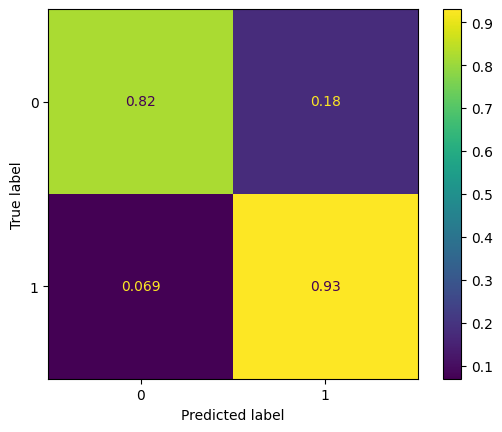

In [41]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, np.round(m.predict(X_test)), normalize='true'))
cm.plot()

In [42]:
m.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (64, 400, 32)          │     4,838,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (64, 400, 32)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (64, 400, 128)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (64, 400, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (64, 400, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (64, 64)               │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (64, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (64, 16)               │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (64, 16)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (64, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,725,637 (56.17 MB)

 Trainable params: 4,908,417 (18.72 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 9,816,836 (37.45 MB)

In [51]:

predict_sentiment("This movie was so good, I loved it!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


'Positive'